#Projet DepLearning - Jos DEFORGES - Pierre HERNOT - Victor VATTIER

### Sujet : Classification de types de coups au Tennis (données temporelles d'accélération et de gyroscope)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving new_data_all_7.mat to new_data_all_7.mat


# Préparation des données

Notre jeu de données contient des mesures d'accélération et de gyroscope enregistrées pour différents types de coups au tennis, avec un accéléromètre positionné sur le manche de la raquette. L'objectif est de pouvoir labelliser automatiquement le coup réalisé en fonction des variables d'accélération et de gyroscope.

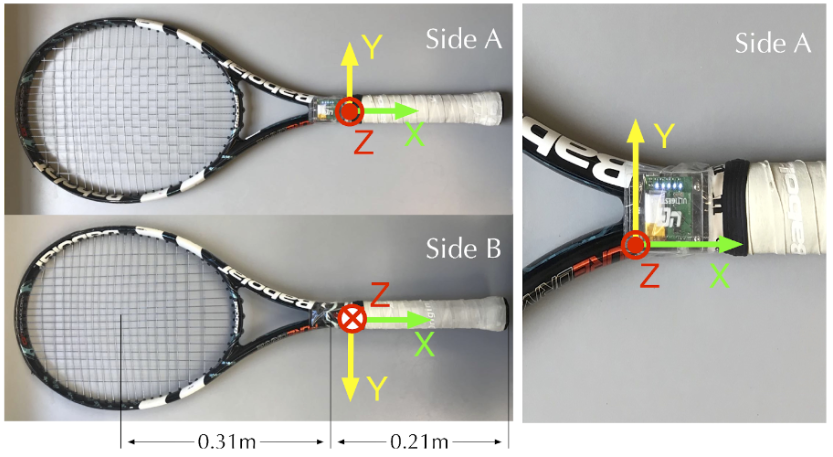

 Chaque coup est représenté par 100 lignes de données, comprenant six variables prédictives (AccX, AccY, AccZ, GyrX, GyrY, GyrZ) et une variable cible (Labels) indiquant le type de coup (0 pour Service, 1 pour Coup droit de fond,2 pour le revers de fond, 3 pour le coup droit de vollée et 4 pour le revers de vollée). Après le chargement des données, elles sont normalisées et redimensionnées en un tableau 3D de taille (2013, 100, 6), représentant 2013 coups de 100 frames chacun, avec six variables d'intérêt. La variable à prédire (Labels) est un vecteur unidimensionnel de taille (2013,).



In [ ]:
import pandas as pd
import scipy
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler


file_path = 'new_data_all_7.mat'


# Charger le fichier .mat
mat_data = scipy.io.loadmat(file_path)


# Extraire les données et les labels
all_data = mat_data['all_data']
all_data_label = mat_data['all_data_label']
# Corriger l'attribution des labels pour s'assurer que chaque enregistrement dans une séquence a le label correspondant


df_list_corrected = []  # Nouvelle liste pour stocker les DataFrames corrigés


# Boucle sur chaque sujet
for i in range(all_data.shape[0]):
    # Extraire les données et les labels pour le sujet courant
    subject_data = all_data[i, 0]
    subject_label = all_data_label[i, 0]


    # Boucle sur chaque coup pour le sujet courant
    for j in range(subject_data.shape[0]):
        # Extraire les données et le label pour le coup courant
        coup_data = subject_data[j, 0]
        coup_label = subject_label[j, 0][0, 0]  # Prendre le premier label du coup, supposé être le même pour toutes les lignes


        # Convertir les données en DataFrame
        coup_df = pd.DataFrame(coup_data, columns=["AccX", "AccY", "AccZ", "GyrX", "GyrY", "GyrZ"])


        # Ajouter la colonne de labels avec la valeur uniforme pour toutes les lignes
        coup_df['Label'] = coup_label


        # Ajouter le DataFrame corrigé à la nouvelle liste
        df_list_corrected.append(coup_df)


# Concaténer tous les DataFrames corrigés en un seul DataFrame
final_df_corrected = pd.concat(df_list_corrected, ignore_index=True)


# Afficher les premières lignes du DataFrame final pour vérifier
#print(final_df_corrected.head())


# séparation en data et labels pour la normalisation
data = final_df_corrected.iloc[:, :-1]  # Les 6 premières colonnes
labels = final_df_corrected.iloc[:, -1]#


# Normlisation MinMax (colonne par colonne)
scaler = MinMaxScaler()
# Appliquer MinMaxScaler aux colonnes de données d'accéléromètre et de gyroscope
data = scaler.fit_transform(data)  # Colonnes AccX à GyrZ


# on transmorme en dataframe
normalized_df = pd.DataFrame(data, columns=["AccX", "AccY", "AccZ", "GyrX", "GyrY", "GyrZ"])
normalized_df['Label'] = labels.values  # Ajouter la colonne des labels
print(normalized_df.head())
# Reshape pour créer un array 3D
data3D = normalized_df.to_numpy().reshape((-1, 100, 7))


# Séparation en X et Y
X = data3D[:, :, :6]  # Toutes les colonnes sauf la dernière
Y = data3D[:, 0, 6]


print(X.shape)
print(Y.shape)
print(Y)

       AccX      AccY      AccZ      GyrX      GyrY      GyrZ  Label
0  0.470215  0.508598  0.555230  0.575860  0.539223  0.407373      1
1  0.481112  0.510582  0.555200  0.577996  0.538018  0.405410      1
2  0.491067  0.511101  0.555306  0.575235  0.536873  0.403493      1
3  0.499961  0.509865  0.553567  0.569696  0.536263  0.401326      1
4  0.503318  0.509239  0.549096  0.564187  0.536538  0.398687      1
(2013, 100, 6)
(2013,)
[1. 0. 0. ... 0. 0. 0.]


## Séparation du jeu de données en deux jeux Train et Test

### Transformation des Y en one hot

Ici, nous utilisons 'train_test_split' pour séparer les données en ensembles d'entraînement, de validation et de test, puis nous convertissons les labels en format one-hot avec 'to_categorical'.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
#Séparation du jeu de données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

#Séparation du jeu de données train en deux : Train et validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
y_train_oh = to_categorical(y_train, num_classes=5, dtype='float32')
y_valid_oh = to_categorical(y_val, num_classes=5, dtype='float32')
y_test_oh = to_categorical(y_test, num_classes=5, dtype='float32')

print(X_val.shape)
print(y_train_oh[1140:1150])

(403, 100, 6)
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


# Modèle MLP

In [ ]:
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras import Model, Sequential
import time
from keras.callbacks import EarlyStopping

#Pour les modèles MLP, il faut “aplatir” la matrice de chaque coup en un vecteur 1D.

# Aplatissez la matrice 3D en une matrice 2D

# Utilisez reshape pour aplatir la deuxième dimension
X_train_2d = X_train.reshape((1207, -1))
X_val_2d = X_val.reshape((403, -1))
X_test_2d = X_test.reshape((403, -1))


# On vérifie les dimensions de la nouvelle matrice
print(X_train_2d.shape)
print(X_val_2d.shape)
print(X_test_2d.shape)

#Modèle MLP 1,2 ou 3 couches cachées



def model_mlp_1c (input_s,n_classes) :
  model = Sequential([
    		InputLayer(input_shape=(input_s,)),
    		Dense(units=128, activation="relu"),
    		Dense(units=n_classes, activation="softmax")
  ])
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  model.summary()
  return model

def model_mlp_2c (input_s,n_classes) :
  model = Sequential([
    		InputLayer(input_shape=(input_s,)),
    		Dense(units=128, activation="relu"),
        Dense(units=128, activation="relu"),
    		Dense(units=n_classes, activation="softmax")
  ])
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  model.summary()
  return model

def model_mlp_3c (input_s,n_classes) :
  model = Sequential([
    		InputLayer(input_shape=(input_s,)),
    		Dense(units=128, activation="relu"),
        Dense(units=128, activation="relu"),
    		Dense(units=128, activation="relu"),
    		Dense(units=n_classes, activation="softmax")
  ])
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  model.summary()
  return model

model_mlp_1 = model_mlp_1c(600,5)
model_mlp_2 = model_mlp_2c(600,5)
model_mlp_3 = model_mlp_3c(600,5)

cb_es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#L’entraînement est arrêté dès qu’il atteint 10 epochs consécutives sans amélioration de la perte de validation.

print("-------------------- Modèle MLP 1 couche ---------------------")
history_mlp_1 = model_mlp_1.fit(X_train_2d, y_train_oh, verbose=2, epochs=100, batch_size=200,callbacks=[cb_es], validation_data=(X_val_2d,y_valid_oh))

print("-------------------------------- Modèle MLP 2 couches ------------------------------")

history_mlp_2 = model_mlp_2.fit(X_train_2d, y_train_oh, verbose=2, epochs=100, batch_size=200,callbacks=[cb_es], validation_data=(X_val_2d,y_valid_oh))

print(" -------------------------- Modèle MLP 3 couches ---------------------------------")
start_time = time.time()
history_mlp_3 = model_mlp_3.fit(X_train_2d, y_train_oh, verbose=2, epochs=100, batch_size=200,callbacks=[cb_es], validation_data=(X_val_2d,y_valid_oh))
end_time = time.time()
execution_time_mlp_3 = end_time - start_time




(1207, 600)
(403, 600)
(403, 600)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               76928     
                                                                 
 dense_19 (Dense)            (None, 5)                 645       
                                                                 
Total params: 77573 (303.02 KB)
Trainable params: 77573 (303.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               76928     
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                          


#### On observe parmi ces trois modèle lequel est le plus performant

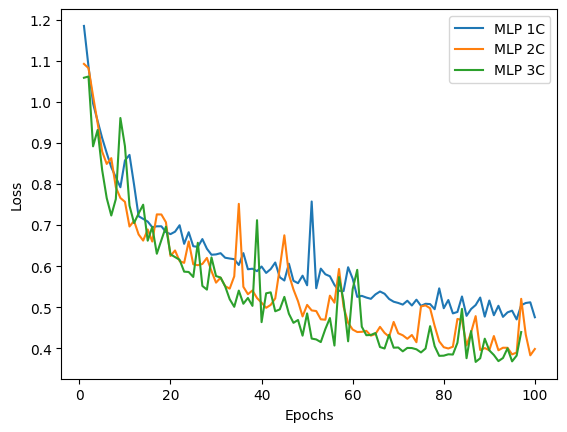

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, 101)
plt.plot(epochs, history_mlp_1.history["val_loss"],label = 'MLP 1C')
plt.plot(epochs, history_mlp_2.history["val_loss"],label = 'MLP 2C')
plt.plot(range(1,98), history_mlp_3.history["val_loss"],label = 'MLP 3C')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

On sélectionne donc le MLP 3 couches.

## Avec le jeu de données de test.

# Modèle RNN LSTM 4 couches Bidirectionnelles

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Flatten, Dense

def model_lstm_4couches_bi(T, D, nb_classes):
  enter = Input(shape = (T, D))
  LSTM_1 = Bidirectional(LSTM(units = 128,return_sequences= True))(enter)
  LSTM_2 = Bidirectional(LSTM(units = 128,return_sequences= True))(LSTM_1)
  LSTM_3 = Bidirectional(LSTM(units = 64,return_sequences= True))(LSTM_2)
  LSTM_4 = Bidirectional(LSTM(units=64,return_sequences= True))(LSTM_3)
  flat = Flatten()(LSTM_4)
  sortie = Dense(units = nb_classes,activation = 'softmax')(flat)
  model = Model(inputs = enter,outputs = sortie)
  model.compile(optimizer="adam", loss= "categorical_crossentropy", metrics = ["accuracy"])
  model.summary()
  return model



cb_es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#L’entraînement est arrêté dès qu’il atteint 10 epochs consécutives sans amélioration de la perte de validation.
model_4c = model_lstm_4couches_bi(X_train.shape[1], X_train.shape[2], 5)
start_time = time.time()
history_4c = model_4c.fit(X_train, y_train_oh, epochs=100, batch_size=4,callbacks=[cb_es], validation_data=(X_val,y_valid_oh))
end_time = time.time()
execution_time_4c = end_time - start_time



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 6)]          0         
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          138240    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 100, 128)          98816     
 onal)                                                       

## Avec le jeu de données de test.

13/13 [==============================] - 0s 26ms/step - loss: 0.3840 - accuracy: 0.9032


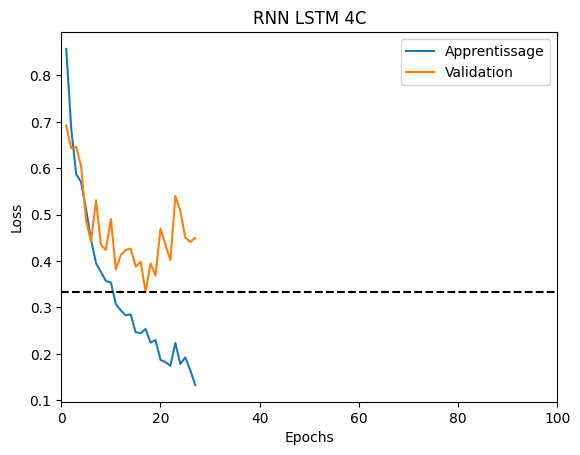

In [ ]:
#Evaluation du modèle
model_4c.evaluate(X_test, y_test_oh)



plt.plot(np.arange(1, len(history_4c.history["loss"]) + 1), history_4c.history["loss"], label="Apprentissage")
plt.plot(np.arange(1, len(history_4c.history["val_loss"]) + 1), history_4c.history["val_loss"], label="Validation")
plt.axhline(y=np.min(history_4c.history["val_loss"]), color="k", linestyle="dashed")
plt.xlim([0, 100])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("RNN LSTM 4C")
plt.legend()

glue("epoch_best_model_es", np.argmin(history_4c.history["val_loss"]) + 1, display=False)


# Modèle RNN 2 couches simples

In [ ]:
from tensorflow.keras.layers import SimpleRNN

def model_rnn_2couches(T, D,nb_classes):
  enter = Input(shape = (T,D))
  RNN_1 = SimpleRNN(units = 64,return_sequences= True)(enter)
  RNN_2 = SimpleRNN(units = 32)(RNN_1)
  sortie = Dense(units = nb_classes,activation = 'softmax')(RNN_2)
  model = Model(inputs = enter,outputs = sortie)
  model.compile(optimizer="adam",loss= "categorical_crossentropy",metrics = ["accuracy"])
  model.summary()
  return model


model_rnn_2c = model_rnn_2couches(X_train.shape[1], X_train.shape[2]
,5)

cb_es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#L’entraînement est arrêté dès qu’il atteint 10 epochs consécutives sans amélioration de la perte de validation.
start_time = time.time()
history_rnn_2c = model_rnn_2c.fit(X_train, y_train_oh, epochs=100, batch_size=4,callbacks=[cb_es],validation_data=(X_val,y_valid_oh))
end_time = time.time()
execution_time_rnn_2c = end_time - start_time

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100, 6)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           4544      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_28 (Dense)            (None, 5)                 165       
                                                                 
Total params: 7813 (30.52 KB)
Trainable params: 7813 (30.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
302/302 [==============================] - 55s 174ms/step - loss: 1.1251 - accuracy: 0.5128 - val_loss: 1.1542 - val_accuracy: 0.5037
Epoch 2/100

## Avec le jeu de données de test.

13/13 [==============================] - 0s 29ms/step - loss: 1.1349 - accuracy: 0.4690


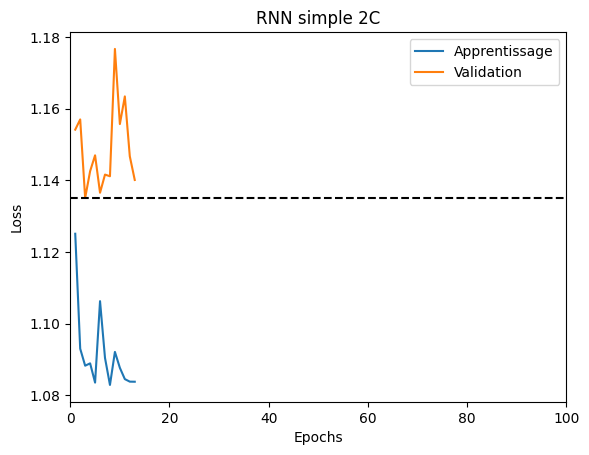

In [ ]:
#Evaluation du modèle
model_rnn_2c.evaluate(X_test, y_test_oh)


plt.plot(np.arange(1, len(history_rnn_2c.history["loss"]) + 1), history_rnn_2c.history["loss"], label="Apprentissage")
plt.plot(np.arange(1, len(history_rnn_2c.history["val_loss"]) + 1), history_rnn_2c.history["val_loss"], label="Validation")
plt.axhline(y=np.min(history_rnn_2c.history["val_loss"]), color="k", linestyle="dashed")
plt.xlim([0, 100])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("RNN simple 2C")
plt.legend()

glue("epoch_best_model_es", np.argmin(history_rnn_2c.history["val_loss"]) + 1, display=False)


# Modèle RNN GRU 4 couches Bidirectionnelles

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, GRU, Flatten, Dense
from tensorflow.keras.models import Model


def model_gru_4couches_bi(T, D, nb_classes):
    enter = Input(shape=(T, D))
    GRU_1 = Bidirectional(GRU(units=128, return_sequences=True))(enter)
    GRU_2 = Bidirectional(GRU(units=128, return_sequences=True))(GRU_1)
    GRU_3 = Bidirectional(GRU(units=64, return_sequences=True))(GRU_2)
    GRU_4 = Bidirectional(GRU(units=64, return_sequences=True))(GRU_3)
    flat = Flatten()(GRU_4)
    sortie = Dense(units=nb_classes, activation='softmax')(flat)
    model = Model(inputs=enter, outputs=sortie)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    return model

cb_es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#L’entraînement est arrêté dès qu’il atteint 10 epochs consécutives sans amélioration de la perte de validation.
start_time = time.time()
model_gru = model_gru_4couches_bi(X_train.shape[1], X_train.shape[2], 5)
history_gru = model_gru.fit(X_train, y_train_oh, epochs=100, batch_size=4,callbacks = [cb_es], validation_data=(X_val,y_valid_oh))
end_time = time.time()
execution_time_gru = end_time - start_time

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 6)]          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 256)          104448    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 100, 256)          296448    
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 100, 128)          123648    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 100, 128)          74496     
 onal)                                                     

## Avec le jeu de données de Test

13/13 [==============================] - 0s 27ms/step - loss: 0.4905 - accuracy: 0.8834


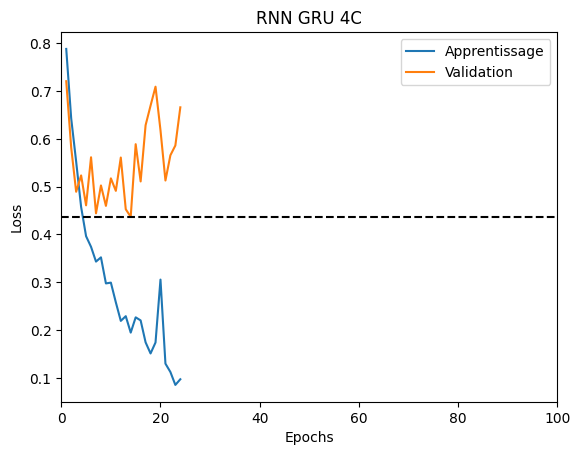

In [ ]:
#Evaluation du modèle
model_gru.evaluate(X_test, y_test_oh)

plt.plot(np.arange(1, len(history_gru.history["loss"]) + 1), history_gru.history["loss"], label="Apprentissage")
plt.plot(np.arange(1, len(history_gru.history["val_loss"]) + 1), history_gru.history["val_loss"], label="Validation")
plt.axhline(y=np.min(history_gru.history["val_loss"]), color="k", linestyle="dashed")
plt.xlim([0, 100])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("RNN GRU 4C")
plt.legend()

glue("epoch_best_model_es", np.argmin(history_gru.history["val_loss"]) + 1, display=False)

# Model Convolutif 4 couches

In [ ]:
from tensorflow.keras.layers import Conv1D


def model_convolutif(T, D, nb_classes):
  input_layer = Input(shape=(T, D))
  conv1 = Conv1D(128, 3, activation='relu')(input_layer)
  conv2 = Conv1D(128, 3, activation='relu')(conv1)
  conv3 = Conv1D(64, 3, activation='relu')(conv2)
  conv4 = Conv1D(64, 3, activation='relu')(conv3)
  flat = Flatten()(conv4)
  dense5 = Dense(32, activation='relu')(flat)
  dense6 = Dense(nb_classes, activation='softmax')(dense5)
  model = Model(input_layer, dense6)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

cb_es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)#L’entraînement est arrêté dès qu’il atteint 10 epochs consécutives sans amélioration de la perte de validation.
conv_net = model_convolutif(X_train.shape[1], X_train.shape[2]
,5)
start_time = time.time()
history_conv_net = conv_net.fit(x=X_train, y=y_train_oh, epochs=100, batch_size=4,callbacks = [cb_es], validation_data=(X_val, y_valid_oh))
end_time = time.time()
execution_time_conv_net = end_time - start_time



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 100, 6)]          0         
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           2432      
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 94, 64)            24640     
                                                                 
 conv1d_3 (Conv1D)           (None, 92, 64)            12352     
                                                                 
 flatten_2 (Flatten)         (None, 5888)              0         
                                                                 
 dense_30 (Dense)            (None, 32)                1884

## Avec les données de test:

13/13 [==============================] - 0s 11ms/step - loss: 0.4276 - accuracy: 0.8834


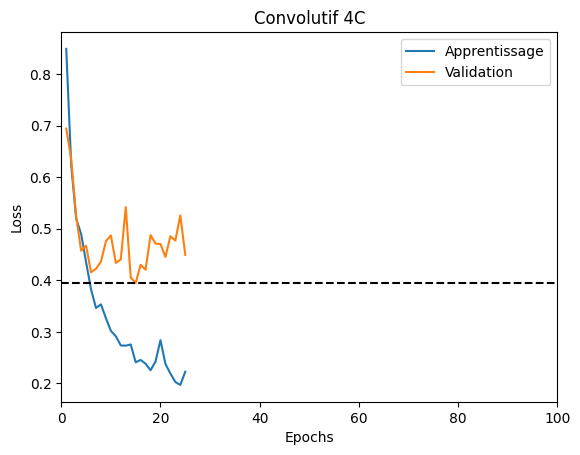

In [ ]:
conv_net.evaluate(X_test, y_test_oh)

plt.plot(np.arange(1, len(history_conv_net.history["loss"]) + 1), history_conv_net.history["loss"], label="Apprentissage")
plt.plot(np.arange(1, len(history_conv_net.history["val_loss"]) + 1), history_conv_net.history["val_loss"], label="Validation")
plt.axhline(y=np.min(history_conv_net.history["val_loss"]), color="k", linestyle="dashed")
plt.xlim([0, 100])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convolutif 4C")
plt.legend()

glue("epoch_best_model_es", np.argmin(history_conv_net.history["val_loss"]) + 1, display=False)

# Comparaison des différents modèles :

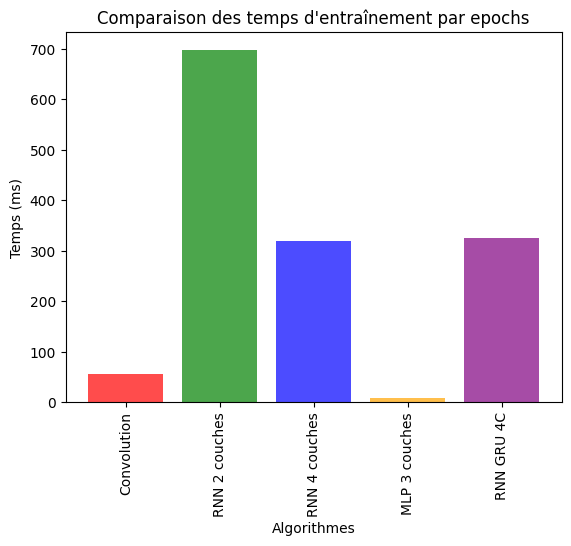

In [ ]:
valeurs = {'Convolution': execution_time_conv_net, 'RNN 2 couches': execution_time_rnn_2c, 'RNN 4 couches': execution_time_4c, 'MLP 3 couches':execution_time_mlp_3, "RNN GRU 4C" : execution_time_gru}


noms = list(valeurs.keys())
valeurs = list(valeurs.values())

couleurs = ['red', 'green', 'blue','orange', "purple"]

bar = plt.bar(noms, valeurs, color=couleurs, alpha=0.7)
plt.xlabel('Algorithmes')
plt.ylabel('Temps (ms)')
plt.xticks(rotation="vertical")
plt.title("Comparaison des temps d'entraînement")


plt.show()



D'après ce graphique, le modèle MLP 3 couches et le modèle convolutif ont les temps d'entraînement les plus courts.

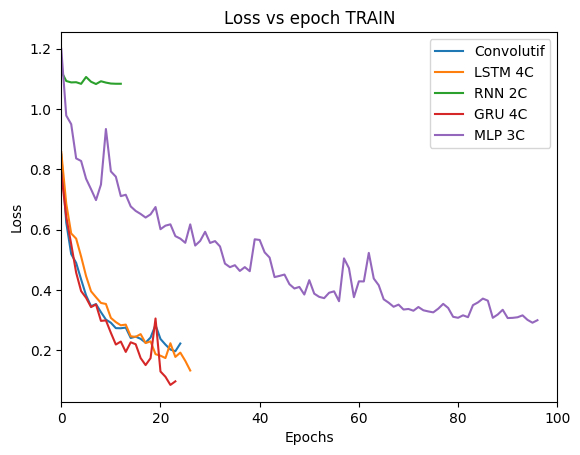

In [ ]:
plt.plot(history_conv_net.history["loss"], label="Convolutif")
plt.plot(history_4c.history["loss"], label="LSTM 4C")
plt.plot(history_rnn_2c.history["loss"], label="RNN 2C")
plt.plot(history_gru.history["loss"], label="GRU 4C")
plt.plot(history_mlp_3.history["loss"], label="MLP 3C")
plt.xlim([0, 100])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title('Loss vs epoch TRAIN')
plt.legend()

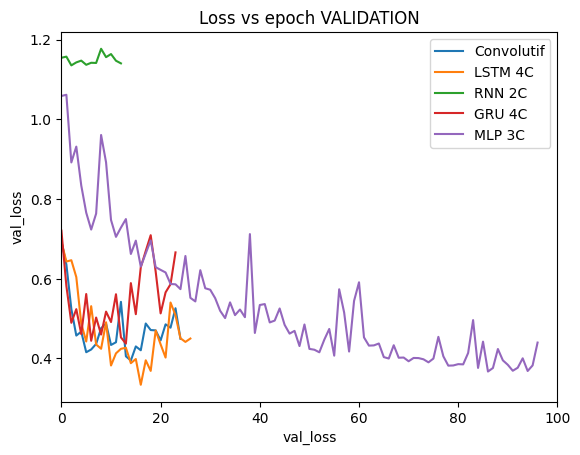

In [ ]:
plt.plot(history_conv_net.history["val_loss"], label="Convolutif")
plt.plot(history_4c.history["val_loss"], label="LSTM 4C")
plt.plot(history_rnn_2c.history["val_loss"], label="RNN 2C")
plt.plot(history_gru.history["val_loss"], label="GRU 4C")
plt.plot(history_mlp_3.history["val_loss"], label="MLP 3C")
plt.xlim([0, 100])
plt.ylabel("val_loss")
plt.xlabel("val_loss")
plt.title('Loss vs epoch VALIDATION')
plt.legend()

13/13 [==============================] - 0s 15ms/step - loss: 0.4905 - accuracy: 0.8834


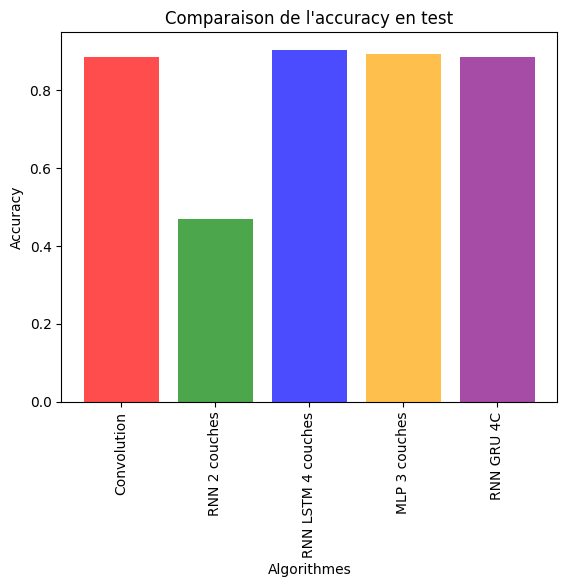

In [ ]:
accuracy1 = model_mlp_3.evaluate(X_test_2d, y_test_oh)[1]
accuracy2 = model_rnn_2c.evaluate(X_test, y_test_oh)[1]
accuracy3 = model_4c.evaluate(X_test, y_test_oh)[1]
accuracy4 = conv_net.evaluate(X_test, y_test_oh)[1]
accuracy5 = model_gru.evaluate(X_test, y_test_oh)[1]



valeurs = {'Convolution': accuracy4, 'RNN 2 couches': accuracy2, 'RNN LSTM 4 couches': accuracy3, 'MLP 3 couches':accuracy1, "RNN GRU 4C" : accuracy5}


noms = list(valeurs.keys())
valeurs = list(valeurs.values())


couleurs = ['red', 'green', 'blue','orange', "purple"]


plt.bar(noms, valeurs, color=couleurs, alpha=0.7)
plt.xticks(rotation="vertical")
plt.xlabel('Algorithmes')
plt.ylabel('Accuracy')

plt.title("Comparaison de l'accuracy en test")



plt.show()

Ici, le meilleur algorithme est le RNN LSTM 4C, qui affiche une précision de 0,90. Ce résultat est suivi de près par le modèle convolutif, le MLP 3C ainsi que le RNN GRU 4C.

Le RNN LSTM 4C est un algorithme de type récurrent, bien adapté aux tâches de traitement du langage naturel. Il est capable de prendre en compte la séquence des données, ce qui lui confère une meilleure précision que les autres algorithmes.

En conclusion, le RNN LSTM 4C se positionne comme le meilleur algorithme pour cette tâche, avec la précision la plus élevée. Néanmoins, les algorithmes MLP à 3 couches et le modèle convolutif présentent également un intérêt, notamment en raison de leur temps d'entraînement plus court par rapport au RNN LSTM 4C. Il est toutefois important de noter qu'il existe une variabilité significative dans les résultats des algorithmes en fonction de l'initialisation des poids. L'utilisation du "Early stopping" avec une "patience" de 10 est également sujette à discussion ; il pourrait être pertinent d'envisager une valeur plus élevée. Une exploration avec un nombre d'epochs supplémentaires aurait engendré des résultats différents.

## Visualisation d'une matrice de confusion avec le modèle RNN LSTM 4 C

13/13 [==============================] - 3s 22ms/step


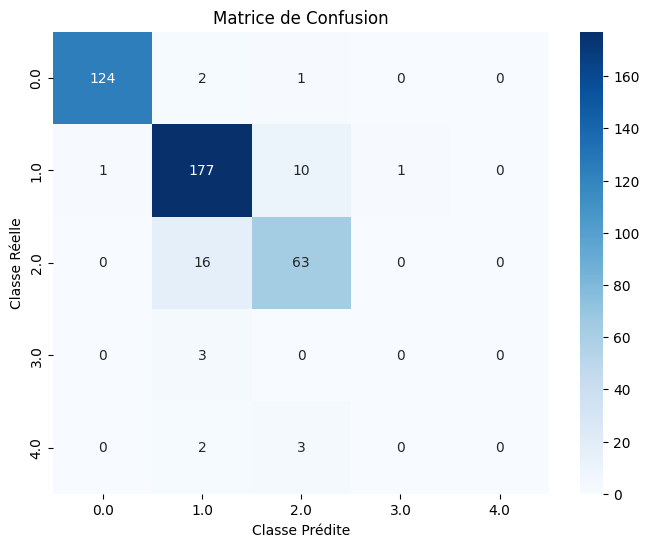

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Après l'entraînement du modèle
y_pred = model_4c.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_oh, axis=1)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)

class_names = np.unique(y_test)


# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.show()



D'après cette matrice de confusion, les labels 0, 1 et 2 (service, coup droit de fond, revers de fond) présentent un pourcentage de bonnes prédictions très élevé. En revanche, tous les labels 3 et 4 (coup droit de volée et revers de volée) ne sont pas bien prédits. Les faibles occurrences des labels 3 et 4 semblent avoir un impact significatif sur les performances de prédiction, car le modèle a moins d'exemples pour apprendre ces classes spécifiques. De plus, la similitude entre les caractéristiques des labels 3 et 4 avec celles des labels 1 et 2 peut conduire à des confusions lors de la prédiction.

Pour améliorer la performance du modèle sur les labels 3 et 4, il pourrait être bénéfique d'augmenter la quantité de données d'entraînement pour ces classes spécifiques, ou d'explorer des techniques de prétraitement des données pour mieux distinguer les caractéristiques distinctives.